In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.utils import torch_mod_to_fcn

from sparse_networks import CenteredBumpFcn
from sparse_networks import FunctionSequenceGenerator
from sparse_networks import plot_2d_f
from sparse_networks import SumOfBumpFcns


## Define objects

In [148]:
class PWL_NNNetwork(torch.nn.Module):
    """ Piecewise linear nearest neighbor network"""
    
    def __init__(self, init_centers: torch.Tensor, init_weights: torch.Tensor, 
                 init_offsets: torch.Tensor, k: int = 1):
        """ Creates a new PWL_NNNetwork. 
        
        Args:
                
            init_centers: Initial centeres for each function. Of shape n_ctrs*input_dim
            
            init_weights: Initial weights for each function. Of shape n_ctrs*input_dim
            
            init_offsets: Initial offsets for each function. Of length n_ctrs
                      
            k: Number of nearest neighbors to use. 
        """
        
        super().__init__()
        
        self.k = k
        self.n_fcns = init_centers.shape[0]
        self.d_in = init_centers.shape[1]
             
        self.ctrs = torch.nn.Parameter(init_centers)
        self.wts = torch.nn.Parameter(init_weights)
        self.offsets = torch.nn.Parameter(init_offsets)
    
    def forward(self, x: torch.Tensor):
        """ Computes output from input. 
        
        Args:
        
            x: Input of shape n_smps*input_dim
            
        Returns: 
            y: Output of shape n_smps*output_dim
        """

        # Find the k closest centers to each data point
        with torch.no_grad():
            ctrs_expanded = torch.reshape(self.ctrs, [self.n_fcns, 1, self.d_in])
            diffs = x - ctrs_expanded
            sq_distances = torch.sum(diffs**2, dim=2)
            top_k_indices = torch.topk(-sq_distances, k=self.k, dim=0).indices
            
        # Compute linear functions applied to each input data point
        selected_wts = self.wts[top_k_indices]
        selected_ctrs = self.ctrs[top_k_indices]
        
        applied_wts = torch.sum(selected_wts, dim=0)
        applied_offsets = (torch.sum(self.offsets[top_k_indices], dim=0) - 
                           torch.sum(torch.sum(selected_wts*selected_ctrs, dim=0), dim=1))
        
        return torch.sum(applied_wts*x, dim=1) + applied_offsets
    
    def bound(self, ctr_bounds: Sequence = [0, 1], bound_fcns: bool =  True):
        """  Applies bounds to the centers.

        Bounds are applied element-wise.

        Args:

            ctr_bounds: The bounds to force centers to be between. If None, no bounds are enforced.
            
            bound_fcns: True if bound should be called on functiions. 

        """

        if ctr_bounds is not None:
            small_inds = self.ctrs < ctr_bounds[0]
            big_inds = self.ctrs > ctr_bounds[1]
            self.ctrs.data[small_inds] = ctr_bounds[0]
            self.ctrs.data[big_inds] = ctr_bounds[1]
        

## Fitting function

In [149]:
def fit(nn: torch.nn.Module, x: torch.Tensor, y: torch.Tensor, n_its = 1000, lr=.01, batch_size: int = None, 
        enforce_bounds: bool = True, update_int: int = 1000):
    """ Fits a neural network. 
    
    Args:
        x: Input data of shape n_smps*d_in
        
        y: Output data of shape n_smps*1
        
        n_its: The number of iterations to run optimization for
        
        lr: The learning rate to use
        
        enforce_bounds: If true, the center of bump functions will be
        constrained to stay in the unit hypercube
        
        update_int: Interval updates are printed
    
    """
    
    params = nn.parameters()
    
    optimizer = torch.optim.Adam(params = params, lr=lr)
    
    n_smps = x.shape[0]
    if batch_size is None:
        batch_size = n_smps
    
    for i in range(n_its):
        
        # Select samples for this iteration 
        if batch_size != n_smps:
            inds = torch.randperm(n_smps)[1:batch_size]
            batch_x = x[inds, :]
            batch_y = y[inds]
        else:
            batch_x = x
            batch_y = y
        
        optimizer.zero_grad()
        
        y_pred = nn(batch_x)
        er = torch.sum((batch_y - y_pred)**2)/batch_size
        er.backward()
        
        optimizer.step()
        
        if enforce_bounds:
            nn.bound()
        
        if i % update_int == 0:
            er_log = float(er.detach().cpu().numpy())
            print('It ' + str(i) +  ': {:e}'.format(er_log))
    

## Generate a ground-truth function we want to fit and visualize it

In [150]:
fcn_generator = FunctionSequenceGenerator(n_bumps = 50, bump_peak_vl_range = [-1, 1], cov_ev_range = [.002, .002])
f_true = fcn_generator.generate(1)

x = np.random.rand(10000,2)
y = f_true(x)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

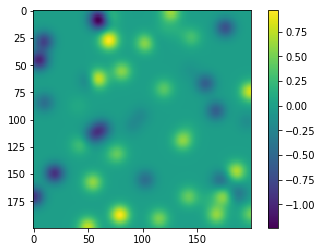

In [151]:
plot_2d_f(f_true, n_smps_per_dim=200)

## Now fit the function

In [171]:
run_on_gpu = True
n_fcns = 1000
k = 5

In [172]:
init_centers = torch.rand(n_fcns, 2)
init_weights = torch.ones(n_fcns, 2)
init_offsts = torch.zeros(n_fcns)

fit_f = PWL_NNNetwork(init_centers=init_centers, init_weights=init_weights, init_offsets=init_offsts, k=k)

In [173]:
if run_on_gpu:
    fit_f.to('cuda')
    x = x.to('cuda')
    y = y.to('cuda')
else:
    fit_f.to('cpu')
    x = x.to('cpu')
    y = y.to('cpu')

In [174]:
lr = .01
enforce_bounds=True
batch_size = 5000

t0 = time.time()

fit(fit_f, x, y, n_its = 2000, lr=lr, batch_size=batch_size, enforce_bounds=enforce_bounds, update_int=100)
    
t_stop = time.time()

print('Elapsed time: ' + str(t_stop - t0))

It 0: 4.747789e-02
It 100: 6.102720e-03
It 200: 3.960887e-03
It 300: 3.060822e-03
It 400: 2.157506e-03
It 500: 2.168275e-03
It 600: 1.876187e-03
It 700: 1.426090e-03
It 800: 1.123423e-03
It 900: 1.009246e-03
It 1000: 1.074484e-03
It 1100: 1.184356e-03
It 1200: 8.448999e-04
It 1300: 8.947838e-04
It 1400: 8.237819e-04
It 1500: 8.315317e-04
It 1600: 7.363465e-04
It 1700: 8.207475e-04
It 1800: 6.744073e-04
It 1900: 6.864573e-04
Elapsed time: 7.150205373764038


In [175]:
fit_f.to('cpu') 
x = x.to('cpu')
y = y.to('cpu')

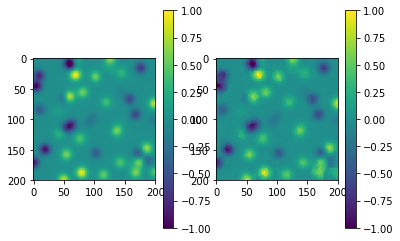

In [176]:
plt.subplot(1,2,1)
plot_2d_f(f_true, n_smps_per_dim=200)
plt.gca().get_images()[0].set_clim(-1,1)
plt.subplot(1,2,2)
plot_2d_f(torch_mod_to_fcn(fit_f), n_smps_per_dim=200)
plt.gca().get_images()[0].set_clim(-1,1)